<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      Text classification
  </div> 
  
<div style="
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
     Finetuning on CTTI-CLF (Albert)
  </div> 


  <div style="
      font-size: 15px; 
      line-height: 12px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Jean-baptiste AUJOGUE
  </div> 


  <div style=" float:right; 
      font-size: 12px; 
      line-height: 12px; 
  padding: 10px 15px 8px;">
  December 2022
  </div>

<a id="TOC"></a>

#### Table Of Content

1. [Dataset](#data) <br>
2. [Albert finetuning](#albert) <br>
3. [Inference](#inference) <br>



#### Reference

- Hugginface full list of [tutorial notebooks](https://github.com/huggingface/transformers/tree/main/notebooks) (see also [here](https://huggingface.co/docs/transformers/main/notebooks#pytorch-examples))
- Huggingface [tutorial notebook](https://github.com/huggingface/notebooks/blob/main/examples/text_classification.ipynb) on text classification
- Huggingface full list of [training scripts](https://github.com/huggingface/transformers/tree/main/examples/pytorch)
- Huggingface [training script](https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py) on text classification
- Huggingface docs on how to [load dataset](https://huggingface.co/docs/datasets/tabular_load#csv-files)
- Huggingface & Pytorch 2.0 [post](https://www.philschmid.de/getting-started-pytorch-2-0-transformers)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import re
import random
import copy
import string

# data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import (
    Dataset, 
    DatasetDict,
    ClassLabel, 
    Features, 
    Sequence, 
    Value,
)
from transformers import DataCollatorWithPadding

# DL
import torch
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    pipeline,
    set_seed,
)
import evaluate

# viz
from IPython.display import HTML

C:\Users\jb\miniconda3\envs\transformers_nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Transformers settings

In [3]:
transformers.__version__

'4.27.1'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Custom paths & imports

In [5]:
path_to_repo = os.path.dirname(os.getcwd())
path_to_data = os.path.join(path_to_repo, 'datasets', 'ctti')
path_to_logs = os.path.join(path_to_repo, 'logs', 'CLF')
path_to_save_mlm = os.path.join(path_to_repo, 'saves', 'MLM')
path_to_save_clf = os.path.join(path_to_repo, 'saves', 'CLF')
path_to_src  = os.path.join(path_to_repo, 'src')

In [6]:
sys.path.insert(0, path_to_src)

In [7]:
# from nlptools.ner.preprocessing import tokenize_and_align_categories, create_labels
# from nlptools.ner.metrics import compute_metrics, compute_metrics_finegrained
# from nlptools.ner.postprocessing import parse_trf_ner_output, remove_entity_overlaps, correct_entity_boundaries
# from nlptools.ner.visualization import render_ner_as_html

#### Constants

We use these variables to build the directories used to collect the outputs of this notebook:

- Finetuning logs will be stored at `logs/CLF/final_model_name/run_name`
- Finetuned model will be stored at `saves/CLF/final_model_name/run_name`


In [8]:
run_name = 'notebook'
dataset_name = 'ctti-clf'
hub_model_name = 'albert-base-v2'
base_model_name = 'albert'
final_model_name = '{}-{}'.format(base_model_name, dataset_name)

<a id="data"></a>

# 1. Dataset

[Table of content](#TOC)

This section is dedicated to loading the dataset, converting it into instances of the `datasets.Dataset` class, and subsequently apply tokenization. For simplicity we load the entire data into RAM, but reading data directly from disk or distant sources remains possible, see the ist of options at Huggingface [dataset loading](https://huggingface.co/docs/datasets/loading) documentation.

Note that the class we use here is different from the `torch.utils.data.Dataset` class. 

## 1.1 Load corpus

[Table of content](#TOC)

In [9]:
df_clf = pd.read_csv(os.path.join(path_to_data, 'ctti-clf.tsv'), sep = "\t").fillna('')
df_nan = df_clf[df_clf.Purpose.str.len() == 0].copy()
df_clf = df_clf[df_clf.Purpose.str.len() > 0].reset_index(drop = True)

df_clf.head(10)

,Id,Summary,Purpose
0,NCT00000102,This study will test the ability of extended r...,Treatment
1,NCT00000106,Recently a non-toxic system for whole body hyp...,Treatment
2,NCT00000108,The purpose of this research is to find out wh...,Prevention
3,NCT00000110,The purpose of this pilot investigation is to ...,Treatment
4,NCT00000111,The purpose of this study is to see if we can ...,Treatment
5,NCT00000113,To evaluate whether progressive addition lense...,Treatment
6,NCT00000114,To determine whether supplements of vitamin A ...,Treatment
7,NCT00000115,To test the efficacy of acetazolamide for the ...,Treatment
8,NCT00000116,The purpose of this trial is to determine whet...,Treatment
9,NCT00000117,To determine whether high-dose intravenous imm...,Treatment


For conveniance we create an instance of `ClassLabel` that keeps the class name - class index alignment in a single object :

In [10]:
class_labels = sorted(list(set(df_clf.Purpose.unique())))
class_labels = ClassLabel(names = class_labels)

In [11]:
label2id = class_labels._str2int
id2label = {i: l for l, i in label2id.items()}

## 1.2 Generate train / valid / test datasets

[Table of content](#TOC)

We split the dataset of 1000 trials into 800 trials for training, 100 trials for validation and 100 trials for testing

In [12]:
df_trn, df_dev = train_test_split(df_clf, train_size = 0.8, random_state = 13, shuffle = True, stratify = df_clf.Purpose)
df_dev, df_tst = train_test_split(df_dev, train_size = 0.5, random_state = 13, shuffle = True, stratify =  df_dev.Purpose)

In [13]:
df_trn.head(3)

,Id,Summary,Purpose
18898,NCT00246363,There is some information available that indic...,Treatment
192274,NCT03221166,Crohn's disease (CD) is a life-long inflammato...,Treatment
257695,NCT04358497,Compare the efficacy and safety of endovascula...,Treatment


After performing the train/dev/test split, we wrap all datasets into a `datasets.DatasetDict`, so that subsequent operations on this data will be performed on this single object:

In [15]:
raw_datasets = DatasetDict({
    'trn': Dataset.from_pandas(df_trn.iloc[:500], preserve_index = False),
    'dev': Dataset.from_pandas(df_dev.iloc[:500], preserve_index = False),
    'tst': Dataset.from_pandas(df_tst.iloc[:500], preserve_index = False),
    'all': Dataset.from_pandas(df_clf.iloc[:500], preserve_index = False),
})

<Axes: ylabel='Frequency'>

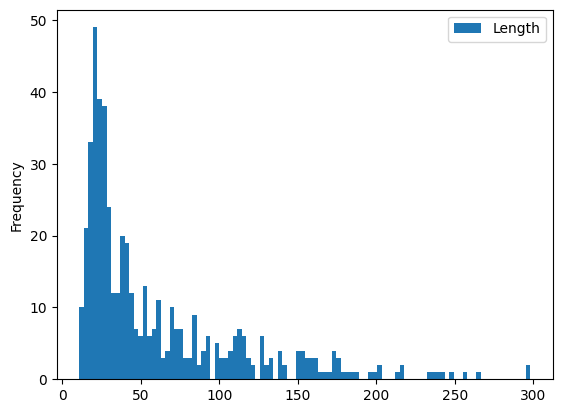

In [16]:
# distribution of lengths
lengths = [len(s.split()) for s in raw_datasets['all']['Summary']]
lengths = [l for l in lengths if l <= 512]

pd.DataFrame(lengths, columns = ['Length']).plot.hist(bins = 100)

The dataset is _heavily_ imbalanced :

<Axes: ylabel='class'>

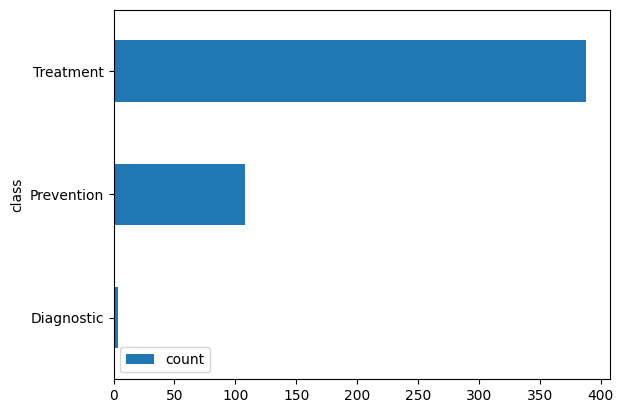

In [17]:
# distribution of classes
classes, counts = np.unique(raw_datasets['all']['Purpose'], return_counts = True)

pd.DataFrame({'class': classes, 'count': counts}).plot.barh(x = 'class', y = 'count')

We can inspect the first item of the test dataset:

In [18]:
for k, v in raw_datasets['tst'][0].items():
    print(k, ':', v)

Id : NCT01687465
Summary : Lasers are important therapy in glaucoma. They are a pivotal point in treatment between medical and surgical care. Over the last 10 years a new laser has emerged as the usual laser treatment: Selective laser trabeculoplasty (SLT). SLT works as well as the older laser used: argon laser trabeculoplasty (ALT). However SLT has many theoretical benefits over ALT including causing less damage to the tissue it affects. One of the potential patient centered benefits of this laser is that it may be repeatable. It is even possible that the old laser ALT may be useable after an SLT treatment. This study aims to uncover whether repeat laser is possible after SLT and if so which laser is more effective (ALT vs SLT). The potential of repeating laser therapies may delay surgical treatment and its complications. Also understanding which laser to use will help eye doctors know how to treat their patients at this point of the disease.
Purpose : Treatment


## 1.3 Apply model-specific tokenization

[Table of content](#TOC)


In [19]:
tokenizer_path = os.path.join(path_to_save_mlm, base_model_name, 'tokenizer')

try:
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    print('Tokenizer loaded from local checkpoint.')
except:
    tokenizer = AutoTokenizer.from_pretrained(hub_model_name)
    tokenizer.save_pretrained(tokenizer_path)
    print('Tokenizer downloaded from Huggingface model hub.')

Tokenizer loaded from local checkpoint.


In [20]:
tokenized_datasets = raw_datasets.map(
    function = lambda examples: tokenizer(examples['Summary'], truncation = True), 
    batched  = True,
)

Additional `tokens`, `token_categories` and `input_ids` columns are available in the newly formed dataset:

In [21]:
for k, v in tokenized_datasets['tst'][0].items():
    print(k, ':', v)

Id : NCT01687465
Summary : Lasers are important therapy in glaucoma. They are a pivotal point in treatment between medical and surgical care. Over the last 10 years a new laser has emerged as the usual laser treatment: Selective laser trabeculoplasty (SLT). SLT works as well as the older laser used: argon laser trabeculoplasty (ALT). However SLT has many theoretical benefits over ALT including causing less damage to the tissue it affects. One of the potential patient centered benefits of this laser is that it may be repeatable. It is even possible that the old laser ALT may be useable after an SLT treatment. This study aims to uncover whether repeat laser is possible after SLT and if so which laser is more effective (ALT vs SLT). The potential of repeating laser therapies may delay surgical treatment and its complications. Also understanding which laser to use will help eye doctors know how to treat their patients at this point of the disease.
Purpose : Treatment
input_ids : [2, 7283, 

<Axes: ylabel='Frequency'>

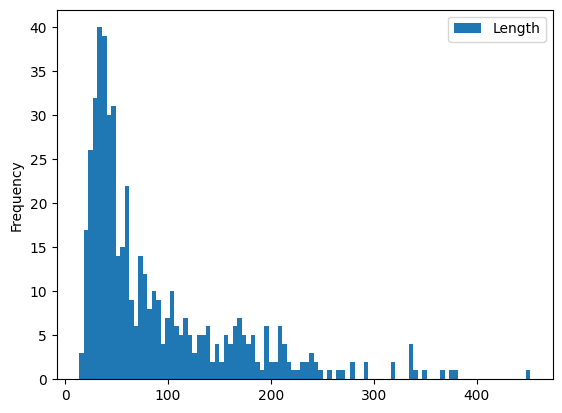

In [22]:
# distribution of lengths
lengths = [len(ts) for ts in tokenized_datasets['all']['input_ids']]

pd.DataFrame(lengths, columns = ['Length']).plot.hist(bins = 100)

## 1.4 Map categories to integers

[Table of content](#TOC)


In [23]:
def create_labels(examples, class_labels):
    examples['label'] = [class_labels.str2int(c) for c in examples['Purpose']]
    return examples

In [24]:
tokenized_datasets = tokenized_datasets.map(
    function = lambda examples: create_labels(examples, class_labels), 
    batched  = True,
)

A new `labels` column is available in the dataset, and corresponds to the integer index, in the `class_labels` object, of the category of each token (or -100 if the category is None) :

In [25]:
for k, v in tokenized_datasets['tst'][0].items():
    print(k, ':', v)

Id : NCT01687465
Summary : Lasers are important therapy in glaucoma. They are a pivotal point in treatment between medical and surgical care. Over the last 10 years a new laser has emerged as the usual laser treatment: Selective laser trabeculoplasty (SLT). SLT works as well as the older laser used: argon laser trabeculoplasty (ALT). However SLT has many theoretical benefits over ALT including causing less damage to the tissue it affects. One of the potential patient centered benefits of this laser is that it may be repeatable. It is even possible that the old laser ALT may be useable after an SLT treatment. This study aims to uncover whether repeat laser is possible after SLT and if so which laser is more effective (ALT vs SLT). The potential of repeating laser therapies may delay surgical treatment and its complications. Also understanding which laser to use will help eye doctors know how to treat their patients at this point of the disease.
Purpose : Treatment
input_ids : [2, 7283, 

### Remarks

- This new dataset depends on the tokenizer, and is therefore _model-specific_.
- The names `input_ids`, `token_type_ids`,  `attention_mask` and `label` present in the dataset are expected by the Classifier model and trainer, and can't be changed.

<a id="albert"></a>

# 2. Model finetuning

[Table of content](#TOC)

## 2.1 BERT model for Sequence Classification

[Table of content](#TOC)

Downloaded checkpoints are by default stored in HF standard cache, which is in our case `C:\Users\me\.cache\huggingface\hub`. This directory can be changed with the `cache_dir` parameter.

In [26]:
# make model creation & training deterministic
set_seed(42)

In [27]:
base_model_path = os.path.join(path_to_save_mlm, base_model_name, 'model')

try:
    model = AutoModelForSequenceClassification.from_pretrained(base_model_path, label2id = label2id, id2label = id2label)
    print('Model loaded from local checkpoint.')
except:
    model = AutoModelForMaskedLM.from_pretrained(hub_model_name)
    model.save_pretrained(base_model_path)
    model = AutoModelForSequenceClassification.from_pretrained(base_model_path, label2id = label2id, id2label = id2label)
    print('Model downloaded from Huggingface model hub.')

Some weights of the model checkpoint at C:\Users\jb\Desktop\NLP\perso - Transformers for NLP\saves\MLM\albert\model were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at C:\Users\jb\Desktop\NLP\perso

Model loaded from local checkpoint.


In [28]:
model.num_parameters()

11691274

In [29]:
model = model.to(device)
model = model.train()

## 2.2 Evaluation metric

[Table of content](#TOC)

During finetuning of our model, we periodically compute performance metrics for the classification task. 

[TO EDIT] The _loss_ function used for the NER task is a [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss), and directly computed by the model (see [source](https://github.com/huggingface/transformers/blob/v4.27.2/src/transformers/models/albert/modeling_albert.py#L1092)) if the expected labels are passed to the model along inputs:

In [71]:
inputs = tokenized_datasets['trn'][0]
input_ids, label = torch.LongTensor([inputs['input_ids']]).to(device), torch.LongTensor([inputs['label']]).to(device)

In [72]:
model(input_ids, labels = label).loss.item()

2.3917429447174072

Metrics other than the training loss are computed using the [seqeval](https://github.com/chakki-works/seqeval) utility package, whose behavior is briefly presented below.

In [35]:
metric = evaluate.load("f1")

Let's see how this metric works:

In [32]:
tokens = tokenized_datasets['tst'][0]['tokens'][1:-1]
labels = tokenized_datasets['tst'][0]['token_categories'][1:-1]

predictions = labels.copy()
predictions[4] = "B-Condition"
# predictions[6] = "I-Condition"

print('tokens :', tokens)
print('labels :', labels)
print('prediction: ', predictions)

metric.compute(predictions = [predictions], references = [labels])

tokens : ['▁are', '▁pregnant', '▁or', '▁lac', 't', 'ating', '▁', '.']
labels : ['O', 'B-Condition', 'O', 'B-Condition', 'I-Condition', 'I-Condition', 'O', 'O']
prediction:  ['O', 'B-Condition', 'O', 'B-Condition', 'B-Condition', 'I-Condition', 'O', 'O']


{'Condition': {'precision': 0.3333333333333333,
  'recall': 0.5,
  'f1': 0.4,
  'number': 2},
 'overall_precision': 0.3333333333333333,
 'overall_recall': 0.5,
 'overall_f1': 0.4,
 'overall_accuracy': 0.875}

The accuracy, precision, recall and f1 score is computed for each category (e.g. any term appearing after a prefix of the form 'B-', 'I-', 'E-', 'S-') encountered in the batch of items to evaluate, along with overall scores.

This metric takes the lists of labels as strings, not integers, so in order to compute performance scores during finetuning, we will need to fully decode the predictions and labels before passing them to the metric. All is cast into the `compute_metrics_finegrained` function, which is passed in argument to the trainer.

## 2.3 Run finetuning on train-valid-test split

[Table of content](#TOC)

This finetuning step is meant to compute and log quality metrics as the finetuning goes. It is run on the train-valid-test split, and consequently the fintuning doesn't benefit from all the available data. To run finetuning on all data, jump to next section

In [42]:
def compute_metrics(p, metric):
    predictions, labels = p
    predictions = np.argmax(predictions, axis = 1)
    
    return metric.compute(predictions = predictions, references = labels, average = 'micro')

In [31]:
batch_size = 6

In [32]:
args = TrainingArguments(
    # training args
    learning_rate = 2e-5,
    weight_decay = 1e-4,
    num_train_epochs = 2,
    
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    bf16 = True,
    torch_compile = False,
    optim = "adamw_torch_fused",
    # logging args
    output_dir = os.path.join(path_to_save_clf, '_checkpoints'),
    logging_dir = os.path.join(path_to_logs, final_model_name, run_name),
    evaluation_strategy = 'steps',
    save_strategy = 'no',
    logging_steps = 50,
    report_to = ['tensorboard'],
    log_level = 'warning',
)

In [43]:
trainer = Trainer(
    model,
    args,
    data_collator = DataCollatorWithPadding(tokenizer),
    train_dataset = tokenized_datasets['trn'],
    eval_dataset  = tokenized_datasets['dev'],
    compute_metrics = lambda p: compute_metrics(p, metric),
)

Remarks:

- The `data_collator` is the object used to batch and pad elements of the training & evaluation datasets.
- The learning rate scheduler is `linear` by default, see also the Huggingface documentation on [schedulers](https://huggingface.co/docs/transformers/v4.27.1/en/main_classes/optimizer_schedules#transformers.SchedulerType).
- Tensor precision is by default `float32`, but other precision are available when using recent GPUs or CPU, see Huggingface post on [floating data types](https://huggingface.co/docs/transformers/v4.15.0/performance#floating-data-types).


-> _inner_training_loop
    - training_step
         loss = model(**inputs)['loss']
         loss.backward()
    - self.optimizer.step()
    - self.lr_scheduler.step()
    - model.zero_grad()

In [44]:
trainer.train()

Step,Training Loss,Validation Loss,F1
50,0.888600,1.278571,0.592000
100,1.142100,1.201297,0.642000
150,0.759400,1.215027,0.642000


TrainOutput(global_step=168, training_loss=0.9141777924128941, metrics={'train_runtime': 46.0498, 'train_samples_per_second': 21.716, 'train_steps_per_second': 3.648, 'total_flos': 13923711718440.0, 'train_loss': 0.9141777924128941, 'epoch': 2.0})

In [45]:
test_results = trainer.evaluate(eval_dataset = tokenized_datasets['tst'], metric_key_prefix = 'test')

In [46]:
for k, v in test_results.items():
    print(str(k) + ' ' + '-'*(30 - len(k)) + ' {:2f}'.format(100*v))

test_loss --------------------- 111.711037
test_f1 ----------------------- 68.200000
test_runtime ------------------ 543.010000
test_samples_per_second ------- 9208.000000
test_steps_per_second --------- 1546.900000
epoch ------------------------- 200.000000


In [47]:
del model

torch.cuda.empty_cache()

## 2.4 Run finetuning on all data

[Table of content](#TOC)

In [48]:
# make model creation & training deterministic
set_seed(42)

In [49]:
base_model_path = os.path.join(path_to_save_mlm, base_model_name, 'model')

model = AutoModelForSequenceClassification.from_pretrained(base_model_path, label2id = label2id, id2label = id2label)

Some weights of the model checkpoint at C:\Users\jb\Desktop\NLP\perso - Transformers for NLP\saves\MLM\albert\model were not used when initializing AlbertForTokenClassification: ['predictions.decoder.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.bias', 'predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at C:\Users\jb\Desktop\NLP\perso - Transform

In [50]:
model = model.to(device)
model = model.train()

In [51]:
batch_size = 6

In [52]:
args = TrainingArguments(
    # training args
    learning_rate = 2e-5,
    weight_decay = 1e-4,
    num_train_epochs = 4,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    bf16 = True,
    torch_compile = False,
    optim = "adamw_torch_fused",
    # logging args
    output_dir = os.path.join(path_to_save_clf, '_checkpoints'),
    evaluation_strategy = 'no',
    save_strategy = 'no',
)

In [53]:
metric = evaluate.load("seqeval")

In [54]:
trainer = Trainer(
    model,
    args,
    data_collator = DataCollatorWithPadding(tokenizer),
    train_dataset = tokenized_datasets['all'],
)

In [55]:
trainer.train()

Step,Training Loss
500,1.037500
1000,0.748900
1500,0.677200
2000,0.676600
2500,0.609400
3000,0.540400
3500,0.520700
4000,0.533400
4500,0.477900
5000,0.441100


TrainOutput(global_step=8424, training_loss=0.5213984827257176, metrics={'train_runtime': 559.7286, 'train_samples_per_second': 90.279, 'train_steps_per_second': 15.05, 'total_flos': 115325300542644.0, 'train_loss': 0.5213984827257176, 'epoch': 4.0})

In [50]:
model = model.to('cpu')

In [57]:
tokenizer.save_pretrained(os.path.join(path_to_save_ner, final_model_name, run_name, 'tokenizer'))
model.save_pretrained(os.path.join(path_to_save_ner, final_model_name, run_name, 'model'))

<a id="inference"></a>

# 3. Inference

[Table of content](#TOC)

In [58]:
tokenizer = AutoTokenizer.from_pretrained(os.path.join(path_to_save_clf, final_model_name, run_name, 'tokenizer'))
model = AutoModelForSequenceClassification.from_pretrained(os.path.join(path_to_save_clf, final_model_name, run_name, 'model'))

In [48]:
clf = pipeline(
    task = 'text-classification', 
    model = model, 
    tokenizer = tokenizer,
    framework = 'pt',
)

In [52]:
clf('I am no medic, but avoiding disease is the best')

[{'label': 'Prevention', 'score': 0.18733863532543182}]

[Table of content](#TOC)